# Binary classification based on 3 layers neural network

## import library & plot functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

In [2]:
def output_plot(g1, g2, title, color, label, legend):
    plt.title(title)
    plt.plot(np.arange(1, len(g1) + 1), g1, color=color[0], alpha=0.5, label=label[0])
    plt.plot(np.arange(1, len(g2) + 1), g2, color=color[1], alpha=0.5, label=label[1])
    plt.legend(loc=legend)
    plt.show()


def output_frame_plot(tloss, vloss, tacc, vacc):
    print("           |   loss   |  accuracy  |")
    print("---------------------------------------")
    print("training   |   %.2f   |    %.2f    |" % (tloss, tacc))
    print("---------------------------------------")
    print("validation |   %.2f   |    %.2f    |" % (vloss, vacc))
    print("---------------------------------------")

## Declare the constants

In [3]:
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNEL = 1
DIMENSION = IMAGE_CHANNEL * IMAGE_HEIGHT * IMAGE_WIDTH

## Load train & validation datasets

* batch size = 3
* number of workers = 1 (main process + worker1)
* number of epoch = 1

In [4]:
def pre_process(batch_size=3, num_workers=1):
    transform = transforms.Compose([  # transforms.Resize((256,256)),
        transforms.Grayscale(),
        # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
        transforms.ToTensor(), ])

    # train_data_path = 'relative path of training data set'
    train_data_path = './horse-or-human/train'
    trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    # if shuffle=True, the data reshuffled at every epoch
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    validation_data_path = './horse-or-human/validation'
    valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    train_data = np.empty((DIMENSION, 0))
    validation_data = np.empty((DIMENSION, 0))

    train_label = np.array([])
    validation_label = np.array([])

    for i, data in enumerate(trainloader):
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]

        # [batch_size, 1, height, width] => [ width * height * channel, batch_size ]
        x = np.array(inputs).transpose((2, 3, 0, 1)).reshape((DIMENSION, len(labels)))
        train_data = np.concatenate((train_data, x), axis=1)
        train_label = np.concatenate((train_label, np.array(labels)))

    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # [batch_size, 1, height, width] => [ width * height * channel, batch_size ]
        x = np.array(inputs).transpose((2, 3, 0, 1)).reshape((DIMENSION, len(labels)))
        validation_data = np.concatenate((validation_data, x), axis=1)
        validation_label = np.concatenate((validation_label, np.array(labels)))

    return train_data, validation_data, train_label, validation_label


t_data, v_data, t_label, v_label = pre_process(batch_size=3, num_workers=1)

## Implements of 3 layers neural network

* (Learning Rate) $\alpha = 0.055$
* (Epsilon) $\mathcal{e} = 10^{-6}$

* $(x_i, y_i)$ denotes a pair of a training example and $`i = 1, 2, \cdots, n$
* $p_i = \sigma(u^T x_i + a)$ (hidden layer)
* $q_i = \sigma(v^T p_i + b)$ (hidden layer)
* $\hat{y}_i = \sigma(w^T q_i + c)$ (output layer)

The logistic function $\sigma$ is defined by $\sigma(z) = \frac{1}{1 + \exp(-z)}$
The loss function is defined by $\mathcal{L} = \frac{1}{n} \sum_{i=1}^n f_i(u, v, w, a, b, c)$

* $f_i(u, v, w, a, b, c) = - y_i \log \hat{y}_i - (1 - y_i) \log (1 - \hat{y}_i)$

### Architecture

![architecture](neural_net2.jpeg)

#### Input layer
* num of features = $10000$ (100 * 100 image)
* num of samples = $1027$ (number of training image samples)

#### hidden layer 1
* num of features (nodes) = $150$
* initial value of parameter : $u \thicksim N(1,0)$
* activation function : sigmoid

#### hidden layer 2
* num of features (nodes) = $50$
* initial value of parameter : $v \thicksim N(1,0)$
* activation function : sigmoid

#### output layer
* num of features (nodes) = $1$
* initial value of parameter : $w \thicksim N(1,0)$
* activation function : sigmoid

In [5]:
def binary_classify(train_data, validation_data, train_label, validation_label):
    num_of_layers = 3
    num_of_nodes = 50
    learning_rate = 0.055
    epsilon = 10e-6

    # INITIALIZE u v z
    u = np.random.randn(DIMENSION+1, num_of_nodes*3)
    v = np.random.randn(num_of_nodes*3, num_of_nodes)
    w = np.random.randn(num_of_nodes, 1)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def d_sigmoid(z):
        return sigmoid(z) * (1 - sigmoid(z))

    def cross_entropy(prob, ans):
        return -(np.nan_to_num(ans * np.log(prob)) + np.nan_to_num((1 - ans) * np.log(1 - prob)))

    def loss(prob, ans):
        return (1 / len(ans)) * np.nan_to_num(np.sum(cross_entropy(prob, ans)))

    def accuracy(prob, ans):
        arr = np.array(list(map(lambda x: 1 if x > 0.5 else 0, prob.flatten())))
        arr = list(filter(lambda x: x == 0, arr - ans))
        return len(arr) / len(ans)

    def du(x, a, b, c, v, cached):
        return (1/c.shape[1]) * np.dot(np.dot(v, np.dot(w, cached) * d_sigmoid(b)) * d_sigmoid(a), x.T)

    def dv(a, b, c, w, cached):
        return (1/c.shape[1]) * np.dot(np.dot(w, cached) * d_sigmoid(b), sigmoid(a).T)

    def dw(b, c, cached):
        return (1/c.shape[1]) * np.dot(cached, sigmoid(b).T)

    def iterate():
        p_train_loss = 0
        nonlocal u, v, w
        nonlocal train_losses, test_losses, train_accuracies, test_accuracies

        train_data_with_bias = np.concatenate((train_data, np.ones((1, train_data.shape[1]))))
        validation_data_with_bias = np.concatenate((validation_data, np.ones((1, validation_data.shape[1]))))

        while True:
            # forward propagation
            a = np.dot(u.T, train_data_with_bias)
            b = np.dot(v.T, sigmoid(a))
            c = np.dot(w.T, sigmoid(b))

            vz = np.dot(u.T, validation_data_with_bias)
            vz = np.dot(v.T, sigmoid(vz))
            vz = np.dot(w.T, sigmoid(vz))

            # back propagation
            cached = (sigmoid(c) - train_label)
            w = w - (learning_rate * dw(b, c, cached)).T
            v = v - (learning_rate * dv(a, b, c, w, cached)).T
            u = u - (learning_rate * du(train_data_with_bias, a, b, c, v, cached)).T

            n_train_loss = loss(sigmoid(c), train_label)
            n_test_loss = loss(sigmoid(vz), validation_label)

            n_train_acc = accuracy(sigmoid(c), train_label)
            n_test_acc = accuracy(sigmoid(vz), validation_label)

            # gathering results
            train_losses.append(n_train_loss)
            test_losses.append(n_test_loss)
            train_accuracies.append(n_train_acc)
            test_accuracies.append(n_test_acc)

            if abs(p_train_loss - n_train_loss) < epsilon:
                break
            else:
                p_train_loss = n_train_loss
                continue

    iterate()

    return train_losses, test_losses, train_accuracies, test_accuracies


t_data, v_data, t_label, v_label = pre_process(batch_size=3, num_workers=1)

train_loss, test_loss, train_acc, test_acc = binary_classify(t_data, v_data, t_label, v_label)

## Plot the learning curves

### loss curve

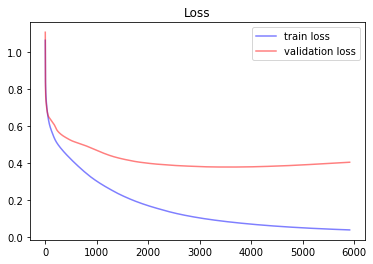

In [6]:
output_plot(train_loss, test_loss,
            title="Loss", color=('blue', 'red'),
            label=('train loss', 'validation loss'), legend='upper right')

### accuracy curve

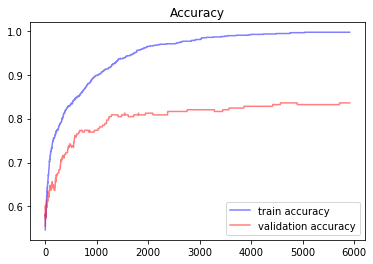

In [7]:
output_plot(train_acc, test_acc,
            title="Accuracy", color=('blue', 'red'),
            label=('train accuracy', 'validation accuracy'), legend='lower right')

### final accuracy and loss

In [8]:
output_frame_plot(train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1])

           |   loss   |  accuracy  |
---------------------------------------
training   |   0.04   |    1.00    |
---------------------------------------
validation |   0.40   |    0.84    |
---------------------------------------
